In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torch.utils.checkpoint import checkpoint

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Data Augumentation**

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = torchvision.datasets.Food101(root='./data',
                                        split='train',
                                        download=True,
                                        transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16,
                                          shuffle=True, pin_memory=True)

test_set = torchvision.datasets.Food101(root='./data',
                                       split='test',
                                       download=True,
                                       transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16,
                                         shuffle=False, pin_memory=True)

100%|██████████| 5.00G/5.00G [03:40<00:00, 22.6MB/s]


Extracting ./data/food-101.tar.gz to ./data


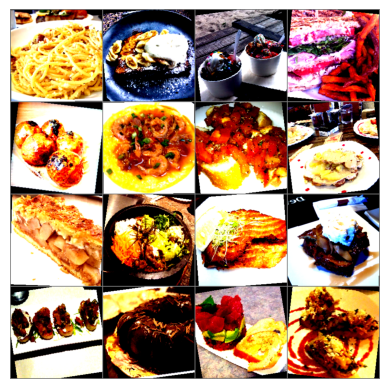

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

num_images_to_show = min(20, len(images))
img_grid = torchvision.utils.make_grid(images[:num_images_to_show], nrow=4)
imshow(img_grid)

if hasattr(train_set, 'classes'):
    print('|'.join(f'{train_set.classes[labels[j]]}' for j in range(num_images_to_show)))
else:
    print(f'Classes não encontradas no dataset.')

# **Modelo e Dataset**

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# **Transfer Learning**

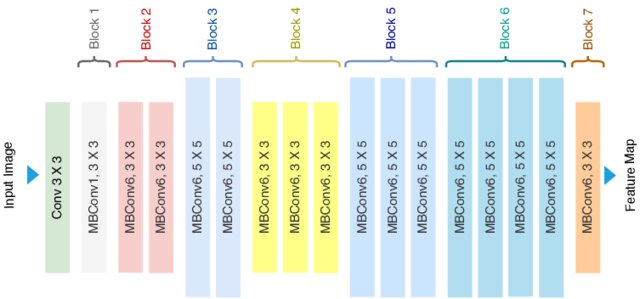

In [ ]:
class FoodClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FoodClassifier, self).__init__()
        self.model = efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        x = self.model.features(x) # Pass through feature extraction layers
        x = self.model.avgpool(x)  # Apply Adaptive Average Pooling
        x = torch.flatten(x, 1)     # Flatten for the classifier
        x = self.model.classifier(x) # Pass through classifier
        return x

spaghetti_carbonara|bread_pudding|frozen_yogurt|club_sandwich|takoyaki|shrimp_and_grits|bruschetta|waffles|apple_pie|bibimbap|grilled_salmon|french_toast|bruschetta|chocolate_cake|tuna_tartare|bruschetta


# **Otimização**

In [ ]:
num_classes = len(train_set.classes)
model = FoodClassifier(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 83.0MB/s]


In [ ]:
model = model.to(device)
print(model)

FoodClassifier(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_

In [ ]:
for images, labels in train_loader:
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    break

Images shape: torch.Size([16, 3, 224, 224]), Labels shape: torch.Size([16])


# **Treinamento**

In [ ]:
steps_per_epoch = len(train_loader)
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0
)

num_epochs = 5
best_val_acc = 0.0
best_model_path = 'best_food_classifier_model.pth'

scaler = torch.cuda.amp.GradScaler()

accumulation_steps = 4

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        if i % accumulation_steps == 0:
            optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels) / accumulation_steps
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * images.size(0) * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_train
    epoch_acc = 100 * correct_train / total_train
    print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    model.eval()
    total_val = 0
    correct_val = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_running_loss / total_val
    val_acc = 100 * correct_val / total_val
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'Model saved with Validation Accuracy: {best_val_acc:.2f}%')

Epoch [1/5]


<ipython-input-10-cdefd976d361>:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-10-cdefd976d361>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 3.5494, Train Accuracy: 29.63%
Validation Loss: 2.2807, Validation Accuracy: 58.94%
Model saved with Validation Accuracy: 58.94%
Epoch [2/5]
Train Loss: 2.3854, Train Accuracy: 55.34%
Validation Loss: 1.8087, Validation Accuracy: 70.76%
Model saved with Validation Accuracy: 70.76%
Epoch [3/5]
Train Loss: 2.0741, Train Accuracy: 62.99%
Validation Loss: 1.6566, Validation Accuracy: 74.83%
Model saved with Validation Accuracy: 74.83%
Epoch [4/5]
Train Loss: 1.9191, Train Accuracy: 67.43%
Validation Loss: 1.5578, Validation Accuracy: 77.81%
Model saved with Validation Accuracy: 77.81%
Epoch [5/5]
Train Loss: 1.8169, Train Accuracy: 70.35%
Validation Loss: 1.5151, Validation Accuracy: 79.14%
Model saved with Validation Accuracy: 79.14%


# **Resultados**

In [ ]:
model.load_state_dict(torch.load(best_model_path))
model.eval()
total_test = 0
correct_test = 0
test_running_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = test_running_loss / total_test
test_acc = 100 * correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

<ipython-input-11-31e6c7ebf15d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Loss: 1.5151, Test Accuracy: 79.14%
